<a href="https://colab.research.google.com/github/CS418/group-project-jelabi/blob/main/418_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progress Report- Team Jalebi

## Project introduction:
The data we are analyzing is publicly accessible and located at https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp.
It can be quickly accessed as a CSV file or through an API
Depending on the year, each dataset contains roughly between 250,000-300,000 rows of reported crimes
Each row contains various pieces of information about every reported crime, including location, timestamp, type, etc. 
We plan to answer few of the below questions:
1. Which time of the day is safe?
2. Which day of the week is most prone to crimes?
3. What are the most common crimes?

## Any changes:
The scope has not changed since the check-in proposal slides.
- With crime on the rise in the city, it’s important to understand for students and all residents alike where extra precautions must be taken when traveling, as well as when it should be done.

In [70]:
!pip install psycopg2-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import scipy as sc
import math
import io
import matplotlib
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns

import pandas as pd
!pip install sodapy
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofchicago.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofchicago.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 200000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("9hwr-2zxp", limit=200000)

# Convert to pandas DataFrame
dfOriginal = pd.DataFrame.from_records(results)
#dfOriginal = pd.read_csv('/content/Crimes_-_2022.csv')
dfOriginal.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,date,location,district,block,y_coordinate,latitude,description,location_description,updated_on,community_area,...,ward,case_number,year,domestic,fbi_code,longitude,beat,primary_type,arrest,id
0,2022-10-28T23:57:00.000,"{'latitude': '41.888969704', 'human_address': ...",011,004XX N CENTRAL PARK BLVD,1902734,41.888969704,ATTEMPT - AUTOMOBILE,STREET,2022-11-04T16:48:00.000,23,...,27,JF453485,2022,False,07,-87.716583236,1122,MOTOR VEHICLE THEFT,False,12875557
1,2022-10-28T23:55:00.000,"{'latitude': '41.774783621', 'human_address': ...",008,068XX W 64TH PL,1860987,41.774783621,DOMESTIC BATTERY SIMPLE,RESIDENCE,2022-11-04T16:48:00.000,64,...,23,JF453490,2022,True,08B,-87.791766285,0812,BATTERY,False,12875248
2,2022-10-28T23:54:00.000,"{'latitude': '41.682562165', 'human_address': ...",005,001XX E 116TH ST,1827724,41.682562165,AGGRAVATED - HANDGUN,ALLEY,2022-11-04T16:48:00.000,53,...,9,JF453482,2022,False,04B,-87.620122066,0532,BATTERY,False,12875208
3,2022-10-28T23:54:00.000,"{'latitude': '42.016906591', 'human_address': ...",024,074XX N CLARK ST,1949438,42.016906591,SIMPLE,NURSING / RETIREMENT HOME,2022-11-04T16:48:00.000,1,...,49,JF453478,2022,False,08B,-87.675365909,2422,BATTERY,False,12875327
4,2022-10-28T23:51:00.000,"{'latitude': '41.722768379', 'human_address': ...",006,0000X W CTA 95TH ST LN,1842365,41.722768379,STRONG ARM - NO WEAPON,CTA PLATFORM,2022-11-04T16:48:00.000,49,...,21,JF453531,2022,False,03,-87.624410361,0634,ROBBERY,False,12875211


In [72]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Data Cleaning**

### Data cleaning: Cleaning by dropping unneeded columns

In [73]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on','id', 'x_coordinate', 'y_coordinate', 'location']) #Cleaning by dropping unneeded columns

### Exploratory data analysis: 

The data is primarily a large set of reported crime incidents. It contains a variety of important attributes for each crime, including but not limited to its location, the type of crime, the timestamp, whether or not it resulted in an arrest, etc. This dataset seems to heavily focus on location interestingly enough, as it has a variety of different attributes related to it such as coordinates, address, ward number, etc.

Below are some wordclouds showing the relative frequency of crime types and locations.

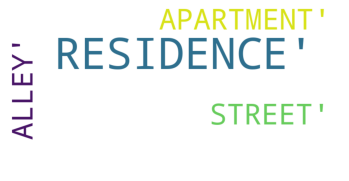

In [74]:
text = df['location_description'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

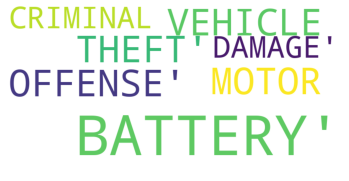

In [75]:
text = df['primary_type'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Some more data cleaning

In [76]:
# Merging certain similar features
#df = dfOriginal.drop(columns=['case_number', 'iucr', 'beat', 'fbi_code', 'updated_on']) #Cleaning by dropping unneeded columns
df.loc[df["primary_type"] == "MOTOR VEHICLE THEFT", "primary_type"] = "THEFT"
df.loc[df["primary_type"] == "CRIMINAL SEXUAL ASSAULT", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "BATTERY", "primary_type"] = "ASSAULT"
df.loc[df["primary_type"] == "CRIMINAL TRESPASS", "primary_type"] = "BURGLARY"
df.loc[df["primary_type"] == "INTERFERENCE WITH PUBLIC OFFICER", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "OBSCENITY", "primary_type"] = "PUBLIC PEACE VIOLATION"
df.loc[df["primary_type"] == "PUBLIC INDECENCY", "primary_type"] = "SEX OFFENSE"
df.loc[df["primary_type"] == "CONCEALED CARRY LICENSE VIOLATION", "primary_type"] = "WEAPONS VIOLATION"
df.loc[df["primary_type"] == "OTHER NARCOTIC VIOLATION", "primary_type"] = "NARCOTICS"


df.isna().sum().sum() #Drop rows with any missing values, very small amount of data


3301

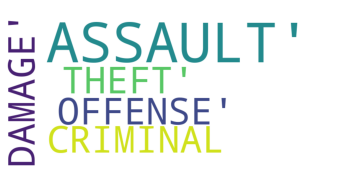

In [77]:
text = df['primary_type'].values 

wordcloud = WordCloud(background_color="white", width=800, height=400).generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

**Data Visualization**

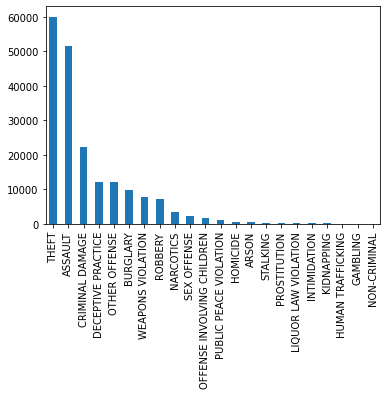

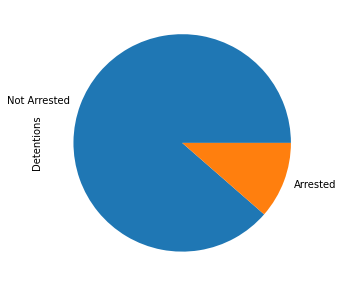

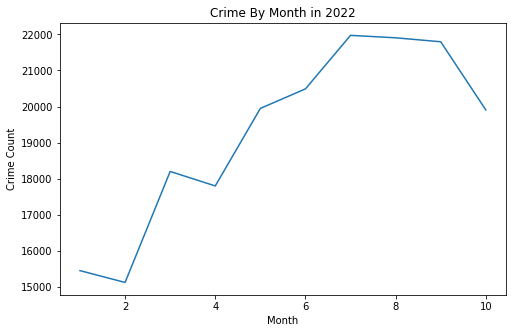

In [78]:
df['primary_type'].value_counts().plot(kind='bar')
plt.show()


arrest_df = df['arrest'].value_counts()
arrest_count = (arrest_df / df['arrest'].sum())
arrest_count.rename("Detentions",inplace=True)
arrest_count.rename({True: 'Arrested', False: 'Not Arrested'},inplace=True)
arrest_count.plot.pie(y=1, figsize=(5, 5))
plt.show()

crimeDate = df.copy(deep=True)
crimeDate.date = pd.to_datetime(crimeDate.date, format = '%Y-%m-%dT%H:%M:%S.000')
crimeDate.index = pd.DatetimeIndex(crimeDate.date)

plt.figure(figsize = (8,5))
crimeDate.groupby([crimeDate.index.month]).size().plot.line()

plt.title('Crime By Month in 2022')
plt.ylabel('Crime Count')
plt.xlabel('Month')
plt.show()

3 visualizations are listed above. Contrary to popular opinion and our hypothesis, homicide was nowhere near the top number of crimes committed in Chicago. Theft and assault accounted for a majority. 

In addition, out of most reported crimes, only about 1/8 of them resulted in arrests. We had hypothesized this, as many crimes go unsolved in Chicago.

Lastly, the final graph shows that crime rises significantly during the warmer spring and summer months, before falling in the winter and fall. This lines up with our hypothesis, as harsher weather depresses all sorts of activity. 

**Random Forest Classifier Analysis**

In this, we used the positional data of a crime and the hour of the day to try and predict what type of crime it would be. This random forest analysis was not very accurate, with a score of only 33%. 

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score

dfForest = dfOriginal.copy(deep=True)

# Extracting the hour of the day from the date column for each crime
df['dateTemp'] = pd.to_datetime(df['date'])
df['hour'] = df['dateTemp'].dt.hour
df = df.drop(['dateTemp'], axis=1) 

df['primary_type'] = pd.factorize(df["primary_type"])[0]  
df['hour'] = pd.factorize(df["hour"])[0] 
df['longitude'] = pd.factorize(df["longitude"])[0] 
df['latitude'] = pd.factorize(df["latitude"])[0] 

Target = 'primary_type'
Features = ["longitude", "latitude", "hour"]
x, y = train_test_split(df, test_size =0.2, random_state=997)


rf_model = RandomForestClassifier(n_estimators=150, max_depth = 15)

rf_model.fit(X=x[Features],y=x[Target])


result = rf_model.predict(y[Features])
acccuracy = accuracy_score(y[Target], result)
recall = recall_score(y[Target], result, average="weighted")
precision = precision_score(y[Target], result, average="weighted")
f1 = f1_score(y[Target], result, average='micro')
confusion = confusion_matrix(y[Target], result)

print("Scores from Random Forest Classification: ")
print("Accuracy: ", acccuracy)
print("Precision: ", precision)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Confusion Matrix: ")
print(confusion)



Scores from Random Forest Classification: 
Accuracy:  0.32875503050759447
Precision:  0.25603292382261233
F1 Score:  0.32875503050759447
Recall:  0.32875503050759447
Confusion Matrix: 
[[8419 3388    5   75   10    1    8    0    1   11   42    1    0    0
     0    0    0    0    0    0]
 [5978 4127    4   64    9    0    5    2    0    6   20    0    0    0
     0    0    0    0    0    0]
 [ 816  573    1   14    4    0    2    0    0    2    1    0    0    0
     0    0    0    0    0    0]
 [2684 1698    7   38    6    0    4    1    0    7   16    0    0    0
     0    0    0    0    0    0]
 [1219  740    2   17   17    0    0    1    0    4    6    0    0    0
     0    0    0    0    0    0]
 [ 387  276    0    4    0    0    1    0    0    0    4    0    0    0
     0    0    0    0    0    0]
 [ 878  702    1   10    4    0    4    0    0    1    6    0    0    0
     0    0    0    0    0    0]
 [ 255  179    0    3    1    0    0    3    1    1    5    0    0    0
     0  

The only parts we have left is the ML analysis, the Reflection, and the Next Steps in the project report. We will finish the ML analysis by doing some more research on methods as well as sklearn documentation. The other two parts should be quickly completed after that. 

# Reflection

The hardest part of the project was that we did not have memory resources while making the code work and it kept crashing for the big dataset we have used. These were resolved by further trimming the data down and minimizing the features used in some analyses. Our initial insights and results are that the crime rate is definitely higher in the warmer months, and that most don't result in arrests, either because they go unsolved or for other reasons. The CPD has improvement to do in this regard. In addition, only a small fraction of crime in Chicago is actually homicide, so the population isn't as at risk of death as some media makes it out to be. Our biggest problems continue to be hardware, as well as figuring out appropriate ML algorithms to conduct analyses with. In addition, since we're using 2022 data to be up-to-date, we are missing November and December data mostly so that could result in biased analyses. We believe we are on track to finish this project by the end of the semester, and this is definitely worth proceeding with.  


**Next steps**

Going forward, we're looking to finish the visualizations, as well as the additional ML/Statistical Analysis techniques necessary. Ideally, we're planning on completing one or two a week, which should allow us to hit the deadline. We may pull in additional years of data as well if necessary.